In [1]:
# get packages
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# get scripts
import models.safrl as safrl
import models.cafrl as cafrl
import models.frl as frl
import models.modelling as modelling

In [3]:
# generate parameters, let's try to use these as means as SDs of the multivariate normal distribution
# remember SD^2 = variance 

# lists we need
param_names = ['alpha', 'beta', 'theta0', 'eps']
transforms = ['sigmoid', 'exp', None, 'sigmoid']

safrl_m = [-2.27776507,  0.45551557,  0.22610217,  0.85716715]
safrl_v2 = [[ 5.2713735 , -4.84170106,  1.18151316, -0.26141957],
       [-4.84170106,  4.46988876, -0.92516843,  0.23129545],
       [ 1.18151316, -0.92516843,  1.94186732, -0.16297632],
       [-0.26141957,  0.23129545, -0.16297632,  0.14964764]]


#safrl_m = [-1.58492307, -4.28079865,  1.34629341, -1.96027664]
#safrl_v2 = [[ 2.38976213,  0.06861153,  0.2833222 ,  0.74400705],
#       [ 0.06861153,  0.17810315,  0.12736805,  0.11444026],
#       [ 0.2833222 ,  0.12736805,  1.53376863, -0.37084728],
#       [ 0.74400705,  0.11444026, -0.37084728,  0.65551288]]

# vector of means, covariance matrix for multivariate normal
dist = (safrl_m, safrl_v2)

parameters = np.random.multivariate_normal(dist[0], dist[1], 100)
nP = parameters.shape[1]

for x in range(nP):
    if transforms[x] == 'sigmoid':
        parameters[:,x] = 1/(1+np.exp(-parameters[:,x]))
    elif transforms[x] == 'exp':
        parameters[:,x] = np.exp(parameters[:,x])

# simulate 100 ppts
sims = modelling.simulate(model = safrl.simulate, model_args = 0, rng = None, seed = 999, params=parameters, dist=None, N=100, transforms = None, subjects = None)

/tmp/ipykernel_1005162/1211301064.py:25: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  cafrl_parameters = np.random.multivariate_normal(cafrl_u, cafrl_v2, 100)


<Axes: ylabel='Count'>

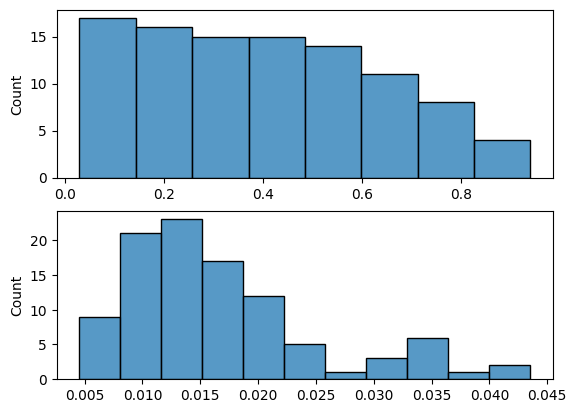

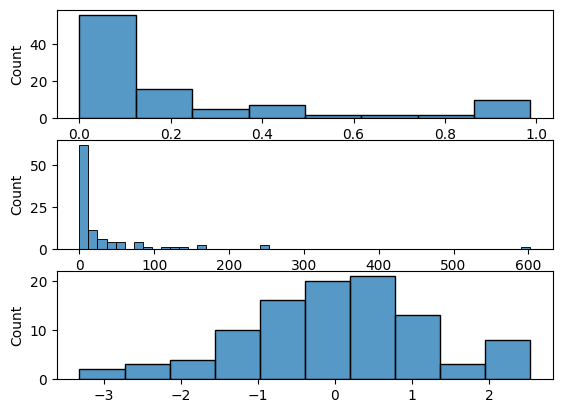

In [48]:
# simulate data with FRL for low learners and CAFRL for high learners

# lists we need
param_names = ['alpha', 'beta', 'theta0', 'eps']
transforms = ['sigmoid', 'exp', None, 'sigmoid']

frl_u = [-0.68846995, -4.14297684]
frl_v2 = [[1.61436504, 0.10214948],
       [0.10214948, 0.19134839]]

frl_parameters = np.random.multivariate_normal(frl_u, frl_v2, 100)
frl_nP = frl_parameters.shape[1]

for x in range(frl_nP):
    if transforms[x] == 'sigmoid':
        frl_parameters[:,x] = 1/(1+np.exp(-frl_parameters[:,x]))
    elif transforms[x] == 'exp':
        frl_parameters[:,x] = np.exp(frl_parameters[:,x])

cafrl_u = [-2.25048609,  0.50316788,  0.13884436]
cafrl_v2 = [[ 6.95034871, -6.08009924,  1.10639494],
       [-6.08009924,  5.37269172, -0.80753339],
       [ 1.10639494, -0.80753339,  1.65390265]]

cafrl_parameters = np.random.multivariate_normal(cafrl_u, cafrl_v2, 100)
cafrl_nP = cafrl_parameters.shape[1]

for x in range(cafrl_nP):
    if transforms[x] == 'sigmoid':
        cafrl_parameters[:,x] = 1/(1+np.exp(-cafrl_parameters[:,x]))
    elif transforms[x] == 'exp':
        cafrl_parameters[:,x] = np.exp(cafrl_parameters[:,x])

# simulate 100 ppts for each model
frl_sims = modelling.simulate(model = frl.simulate, model_args = 0, rng = None, seed = 100, params=frl_parameters, dist=None, N=1000, transforms = None, subjects = None)
cafrl_sims = modelling.simulate(model = cafrl.simulate, model_args = 0, rng = None, seed = 100, params=cafrl_parameters, dist=None, N=1000, transforms = None, subjects = None)

fig, axs = plt.subplots(2)
sns.histplot(frl_parameters[:,0],ax = axs[0])
sns.histplot(frl_parameters[:,1],ax = axs[1])

fig, axs = plt.subplots(3)
sns.histplot(cafrl_parameters[:,0],ax = axs[0])
sns.histplot(cafrl_parameters[:,1],ax = axs[1])
sns.histplot(cafrl_parameters[:,2],ax = axs[2])



In [41]:
x = sims['data'][0]

for i in range(len(sims['data'])):
    if i == 0:
        n_trials = sims['data'][0]['n_trials']
        stages_attempted = sims['data'][0]['stages_attempted']
        tmp_data = pd.DataFrame({'n_trials': n_trials,
             'stages_attempted': stages_attempted})
        tmp_data['subject_nr'] = 0
        tmp_data['alpha'] = sims['params'][i][0]
        tmp_data['temp'] = sims['params'][i][1]
        tmp_data['theta0'] = sims['params'][i][2]
        tmp_data['eps'] = sims['params'][i][3]
    else:
        n_trials = sims['data'][i]['n_trials']
        stages_attempted = sims['data'][i]['stages_attempted']
        tmp_data2 = pd.DataFrame({'n_trials': n_trials,
             'stages_attempted': stages_attempted})
        tmp_data2['subject_nr'] = i
        tmp_data2['alpha'] = sims['params'][i][0]
        tmp_data2['temp'] = sims['params'][i][1]
        tmp_data2['theta0'] = sims['params'][i][2]
        tmp_data2['eps'] = sims['params'][i][3]
        tmp_data = pd.concat([tmp_data, tmp_data2])


plt.figure(figsize=(8, 6), dpi=80)
fig = sns.lineplot(data = tmp_data, x='stages_attempted', y='n_trials')


IndexError: index 3 is out of bounds for axis 0 with size 3

In [49]:
# lets calculate average trials to criterion by stage 
sims = cafrl_sims
#stages = ['SD', 'CD', 'IDS_1', 'IDS_2', 'IDS_3', 'IDS_4', 'EDS', 'EDSR']

for i in range(len(sims['data'])):
    tmp_data = sims['data'][i]
    n_trials = tmp_data['n_trials']
    stages_attempted = tmp_data['stages_attempted']
    
    tmp_df = pd.DataFrame({
        'n_trials': n_trials,
        'stage': stages_attempted,
        'id': [i] * len(stages_attempted)

    })

    if i == 0:
        tmp = tmp_df
    else:
        tmp = pd.concat([tmp, tmp_df])


<Axes: xlabel='stage', ylabel='n_trials'>

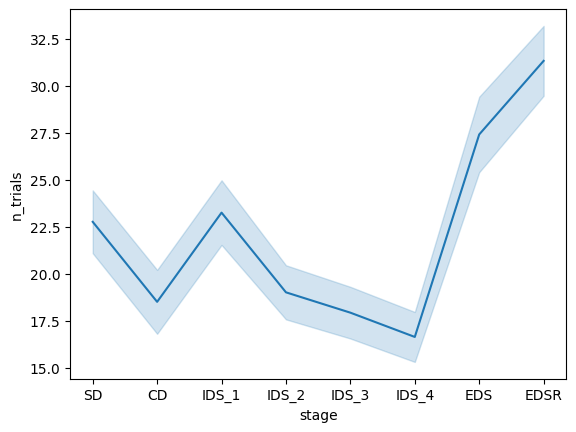

In [50]:
sns.lineplot(tmp, x='stage', y='n_trials', errorbar='se')

In [8]:
fit = modelling.fit(data = sims['data'], nP = 4, fit_func= safrl.fit, fit_args = ['reward', 'choice', 'stim_hist', 'dimension1'], transforms = ['sigmoid', 'exp', None, 'sigmoid'], EM_iter= 100)

Participant: 100it [01:26,  1.16it/s]

Iteration: 1 [-0.35317773 -0.54161148  0.27593879  0.03765568] [[ 0.22350461 -0.06616438 -0.02210194 -0.00355186]
 [-0.06616438  0.08548162  0.01321844  0.00098096]
 [-0.02210194  0.01321844  0.11132634 -0.00082135]
 [-0.00355186  0.00098096 -0.00082135  0.10088048]]



Participant: 100it [01:13,  1.36it/s]

Iteration: 2 [-0.86664746 -0.39632579  0.39215233  0.0629639 ] [[ 0.60445656 -0.30849325 -0.12301761 -0.02877904]
 [-0.30849325  0.21601362  0.08008522  0.01702804]
 [-0.12301761  0.08008522  0.15453634  0.00520874]
 [-0.02877904  0.01702804  0.00520874  0.10415275]]



Participant: 100it [00:59,  1.69it/s]

Iteration: 3 [-1.08715941 -0.29548375  0.44202277  0.07650008] [[ 0.95211046 -0.57773689 -0.23204044 -0.05557803]
 [-0.57773689  0.40687047  0.1651955   0.03831025]
 [-0.23204044  0.1651955   0.19837037  0.01615852]
 [-0.05557803  0.03831025  0.01615852  0.10844111]]



Participant: 100it [00:52,  1.92it/s]

Iteration: 4 [-1.13609142 -0.28249236  0.43794461  0.07577708] [[ 1.2059492  -0.78353049 -0.29921273 -0.06781402]
 [-0.78353049  0.5645983   0.22769596  0.05244714]
 [-0.29921273  0.22769596  0.23769423  0.02877884]
 [-0.06781402  0.05244714  0.02877884  0.11387142]]



Participant: 100it [00:48,  2.07it/s]

Iteration: 5 [-1.15630396 -0.28352096  0.41873701  0.06971484] [[ 1.31124585 -0.89090067 -0.34143477 -0.07910647]
 [-0.89090067  0.65907061  0.26955296  0.06415482]
 [-0.34143477  0.26955296  0.26127394  0.03569335]
 [-0.07910647  0.06415482  0.03569335  0.11788642]]



Participant: 100it [00:55,  1.79it/s]

Iteration: 6 [-1.17509026 -0.28385182  0.39607242  0.06212922] [[ 1.34044986 -0.93920425 -0.36181529 -0.08581544]
 [-0.93920425  0.71029672  0.29339041  0.07153617]
 [-0.36181529  0.29339041  0.28623733  0.04027811]
 [-0.08581544  0.07153617  0.04027811  0.12300774]]



Participant: 100it [00:47,  2.12it/s]

Iteration: 7 [-1.19429284 -0.28246321  0.37089076  0.053669  ] [[ 1.3313338  -0.95344303 -0.36709067 -0.08720386]
 [-0.95344303  0.74209817  0.30401371  0.08120626]
 [-0.36709067  0.30401371  0.29878299  0.04351593]
 [-0.08720386  0.08120626  0.04351593  0.1288956 ]]



Participant: 100it [00:47,  2.10it/s]

Iteration: 8 [-1.21902646 -0.27813717  0.34545971  0.04390954] [[ 1.30615508 -0.95843105 -0.3636143  -0.09161177]
 [-0.95843105  0.75910062  0.30992309  0.08672212]
 [-0.3636143   0.30992309  0.307397    0.0482092 ]
 [-0.09161177  0.08672212  0.0482092   0.13203746]]



Participant: 100it [01:00,  1.64it/s]

Iteration: 9 [-1.23899682 -0.27512426  0.31832035  0.03361544] [[ 1.27639244 -0.95639029 -0.35803784 -0.09418371]
 [-0.95639029  0.76981846  0.31404565  0.09146734]
 [-0.35803784  0.31404565  0.3155986   0.05517958]
 [-0.09418371  0.09146734  0.05517958  0.13779832]]



Participant: 100it [00:48,  2.06it/s]

Iteration: 10 [-1.25719866 -0.27192468  0.2900375   0.02230122] [[ 1.24639412 -0.95180494 -0.35231328 -0.09776389]
 [-0.95180494  0.77841763  0.31850609  0.09385027]
 [-0.35231328  0.31850609  0.32682279  0.0567773 ]
 [-0.09776389  0.09385027  0.0567773   0.15339103]]



Participant: 100it [00:45,  2.19it/s]

Iteration: 11 [-1.27457694 -0.26830107  0.26054385  0.01015869] [[ 1.21822112 -0.94660996 -0.34757706 -0.09961427]
 [-0.94660996  0.78533505  0.32247769  0.09816367]
 [-0.34757706  0.32247769  0.33994578  0.06461625]
 [-0.09961427  0.09816367  0.06461625  0.15911032]]



Participant: 100it [00:51,  1.93it/s]

Iteration: 12 [-1.29121371 -0.26438177  0.22950066 -0.00331986] [[ 1.19321712 -0.94207547 -0.343178   -0.10049239]
 [-0.94207547  0.79206744  0.32631954  0.10191453]
 [-0.343178    0.32631954  0.35616472  0.07452999]
 [-0.10049239  0.10191453  0.07452999  0.16741019]]



Participant: 100it [00:50,  1.97it/s]

Iteration: 13 [-1.30764285 -0.25990092  0.19638548 -0.01878533] [[ 1.17275251 -0.93896085 -0.33677114 -0.10077572]
 [-0.93896085  0.79916758  0.32963237  0.10556562]
 [-0.33677114  0.32963237  0.3758806   0.08529396]
 [-0.10077572  0.10556562  0.08529396  0.17366431]]



Participant: 100it [00:50,  1.98it/s]

Iteration: 14 [-1.3243811  -0.25466752  0.16069064 -0.03629731] [[ 1.15717123 -0.93823541 -0.3322363  -0.10134004]
 [-0.93823541  0.80753333  0.33341503  0.10972174]
 [-0.3322363   0.33341503  0.39445637  0.0984131 ]
 [-0.10134004  0.10972174  0.0984131   0.18386375]]



Participant: 100it [00:46,  2.15it/s]

Iteration: 15 [-1.34181218 -0.24838313  0.12220106 -0.05687921] [[ 1.14416074 -0.93901939 -0.32677361 -0.10003044]
 [-0.93901939  0.81674194  0.33677122  0.11265561]
 [-0.32677361  0.33677122  0.42006597  0.11463748]
 [-0.10003044  0.11265561  0.11463748  0.19715463]]



Participant: 100it [00:47,  2.11it/s]

Iteration: 16 [-1.37171017 -0.2319948   0.07764711 -0.08267544] [[ 1.16476792 -0.96387168 -0.31580027 -0.09309472]
 [-0.96387168  0.8449538   0.33599593  0.11340418]
 [-0.31580027  0.33599593  0.45072506  0.13557139]
 [-0.09309472  0.11340418  0.13557139  0.21618981]]



Participant: 100it [00:52,  1.90it/s]

Iteration: 17 [-1.39621266 -0.21928305  0.0265402  -0.11421388] [[ 1.17872316 -0.98393097 -0.29911983 -0.08409568]
 [-0.98393097  0.86880721  0.33480991  0.11357767]
 [-0.29911983  0.33480991  0.5193736   0.18142126]
 [-0.08409568  0.11357767  0.18142126  0.24891287]]



Participant: 100it [00:49,  2.03it/s]

Iteration: 18 [-1.45018476 -0.18050975 -0.03660976 -0.15752657] [[ 1.2860842  -1.07902609 -0.26507161 -0.04537071]
 [-1.07902609  0.95250501  0.31666003  0.08851988]
 [-0.26507161  0.31666003  0.58273492  0.22860867]
 [-0.04537071  0.08851988  0.22860867  0.29751148]]



Participant: 100it [00:54,  1.83it/s]

Iteration: 19 [-1.56167626 -0.09167636 -0.10423642 -0.21162035] [[ 1.51317683 -1.27280284 -0.18863203  0.02847862]
 [-1.27280284  1.11769124  0.26204605  0.03342911]
 [-0.18863203  0.26204605  0.64566306  0.28348113]
 [ 0.02847862  0.03342911  0.28348113  0.35146823]]



Participant: 100it [00:53,  1.87it/s]

Iteration: 20 [-1.66913905e+00  7.01158487e-04 -1.55502900e-01 -2.49455691e-01] [[ 1.77915409 -1.51031405 -0.12773142  0.09684733]
 [-1.51031405  1.32883101  0.21806746 -0.01950633]
 [-0.12773142  0.21806746  0.707394    0.33425315]
 [ 0.09684733 -0.01950633  0.33425315  0.39902154]]



Participant: 100it [00:47,  2.09it/s]

Iteration: 21 [-1.70528494  0.03633823 -0.18023106 -0.25823625] [[ 1.89489833 -1.62511514 -0.09825297  0.12680445]
 [-1.62511514  1.43956332  0.19575765 -0.04423578]
 [-0.09825297  0.19575765  0.74846028  0.3600173 ]
 [ 0.12680445 -0.04423578  0.3600173   0.41969771]]



Participant: 100it [00:46,  2.15it/s]

Iteration: 22 [-1.71266084  0.04708744 -0.19261284 -0.25278409] [[ 1.93098206 -1.67117149 -0.08372581  0.13426888]
 [-1.67117149  1.4901785   0.18284618 -0.05163705]
 [-0.08372581  0.18284618  0.76774665  0.37439889]
 [ 0.13426888 -0.05163705  0.37439889  0.43044538]]



Participant: 100it [00:42,  2.35it/s]

Iteration: 23 [-1.71338996  0.05067368 -0.20132403 -0.24292684] [[ 1.93581899 -1.6865901  -0.07098865  0.13365079]
 [-1.6865901   1.51160446  0.17155324 -0.05163279]
 [-0.07098865  0.17155324  0.78328778  0.38259863]
 [ 0.13365079 -0.05163279  0.38259863  0.43661736]]



Participant: 100it [00:43,  2.32it/s]

Iteration: 24 [-1.71352447  0.05264747 -0.20873267 -0.23153133] [[ 1.9285964  -1.68949386 -0.06322635  0.1273928 ]
 [-1.68949386  1.52054543  0.16388401 -0.04706154]
 [-0.06322635  0.16388401  0.79878834  0.38534195]
 [ 0.1273928  -0.04706154  0.38534195  0.44037708]]



Participant: 100it [00:41,  2.39it/s]

Iteration: 25 [-1.71433922  0.05438702 -0.21649455 -0.22001116] [[ 1.95090234 -1.71774464 -0.05781964  0.09435296]
 [-1.71774464  1.55145566  0.15845055 -0.01795688]
 [-0.05781964  0.15845055  0.80802292  0.39134507]
 [ 0.09435296 -0.01795688  0.39134507  0.46865306]]



Participant: 100it [00:54,  1.84it/s]

Iteration: 26 [-1.71720585  0.05720768 -0.22704054 -0.2096097 ] [[ 1.93598149 -1.71083105 -0.04625468  0.09490202]
 [-1.71083105  1.55006509  0.14692808 -0.01873398]
 [-0.04625468  0.14692808  0.81054622  0.38899919]
 [ 0.09490202 -0.01873398  0.38899919  0.46799637]]



Participant: 100it [00:45,  2.19it/s]

Iteration: 27 [-1.71892205  0.05892217 -0.23514079 -0.19768882] [[ 1.91954529 -1.70154673 -0.0349603   0.09299904]
 [-1.70154673  1.54532629  0.13603411 -0.01736248]
 [-0.0349603   0.13603411  0.8167274   0.38958392]
 [ 0.09299904 -0.01736248  0.38958392  0.46779528]]



Participant: 100it [01:04,  1.54it/s]

Iteration: 28 [-1.72033823  0.06031043 -0.24154706 -0.18514921] [[ 1.91653338 -1.70424444 -0.0300876   0.08586604]
 [-1.70424444  1.55111807  0.12986952 -0.01194851]
 [-0.0300876   0.12986952  0.81474654  0.38590419]
 [ 0.08586604 -0.01194851  0.38590419  0.46567485]]



Participant: 100it [00:43,  2.32it/s]

Iteration: 29 [-1.72242508  0.06210168 -0.24788605 -0.17302629] [[ 1.91561534 -1.70743971 -0.02359549  0.08077011]
 [-1.70743971  1.55650036  0.12264473 -0.00813813]
 [-0.02359549  0.12264473  0.81407058  0.38210631]
 [ 0.08077011 -0.00813813  0.38210631  0.46462682]]



Participant: 100it [00:56,  1.76it/s]

Iteration: 30 [-1.72452054  0.06387613 -0.25359691 -0.16090888] [[ 1.9145914  -1.7111245  -0.02225325  0.07541401]
 [-1.7111245   1.56267626  0.1195843  -0.00437946]
 [-0.02225325  0.1195843   0.8066156   0.375935  ]
 [ 0.07541401 -0.00437946  0.375935    0.45811812]]



Participant: 100it [01:03,  1.57it/s]

Iteration: 31 [-1.726866    0.06570038 -0.25953742 -0.14945972] [[ 1.91854720e+00 -1.71819124e+00 -1.89472212e-02  7.12795723e-02]
 [-1.71819124e+00  1.57131802e+00  1.15981774e-01 -5.99547725e-04]
 [-1.89472212e-02  1.15981774e-01  8.09361456e-01  3.76227788e-01]
 [ 7.12795723e-02 -5.99547725e-04  3.76227788e-01  4.60930210e-01]]



Participant: 100it [00:54,  1.82it/s]

Iteration: 32 [-1.72894974  0.06728187 -0.26514619 -0.13816933] [[ 1.91925392e+00 -1.72166198e+00 -1.20400082e-02  6.82327523e-02]
 [-1.72166198e+00  1.57641363e+00  1.08696114e-01  1.79648268e-03]
 [-1.20400082e-02  1.08696114e-01  8.10860322e-01  3.72077110e-01]
 [ 6.82327523e-02  1.79648268e-03  3.72077110e-01  4.57219142e-01]]



Participant: 100it [00:43,  2.32it/s]

Iteration: 33 [-1.73115113  0.06906776 -0.26973523 -0.12671975] [[ 1.92699364 -1.73148927 -0.00851577  0.06352735]
 [-1.73148927  1.58707646  0.10478761  0.00565182]
 [-0.00851577  0.10478761  0.81396533  0.369377  ]
 [ 0.06352735  0.00565182  0.369377    0.45598205]]



Participant: 100it [00:42,  2.33it/s]

Iteration: 34 [-1.73340756  0.07089406 -0.27424213 -0.11559329] [[ 1.94130986 -1.74703385 -0.00975569  0.05759435]
 [-1.74703385  1.60293569  0.10615807  0.01150688]
 [-0.00975569  0.10615807  0.82472908  0.37194739]
 [ 0.05759435  0.01150688  0.37194739  0.45758649]]



Participant: 100it [00:42,  2.36it/s]

Iteration: 35 [-1.7358821   0.07284565 -0.27935832 -0.10520349] [[ 1.93857532 -1.74699283 -0.00452973  0.0547793 ]
 [-1.74699283  1.60431053  0.10007353  0.01355283]
 [-0.00452973  0.10007353  0.82560507  0.3689003 ]
 [ 0.0547793   0.01355283  0.3689003   0.45856966]]



Participant: 100it [00:46,  2.17it/s]

Iteration: 36 [-1.73760328  0.07419457 -0.2837772  -0.09478364] [[ 1.94325693 -1.7537286  -0.00224862  0.04698428]
 [-1.7537286   1.61209256  0.09722288  0.02049783]
 [-0.00224862  0.09722288  0.82424962  0.3654678 ]
 [ 0.04698428  0.02049783  0.3654678   0.45996704]]



Participant: 100it [00:48,  2.06it/s]

Iteration: 37 [-1.73977946  0.07589509 -0.28857775 -0.08499763] [[ 1.94616768 -1.75876567  0.00311705  0.04554836]
 [-1.75876567  1.61846065  0.09276514  0.0226616 ]
 [ 0.00311705  0.09276514  0.82978089  0.36634545]
 [ 0.04554836  0.0226616   0.36634545  0.46351813]]



Participant: 100it [00:42,  2.38it/s]

Iteration: 38 [-1.74147773  0.07720403 -0.29274997 -0.0751729 ] [[ 2.16219215 -1.95033979  0.00221524  0.01243213]
 [-1.95033979  1.78796487  0.09252783  0.0520836 ]
 [ 0.00221524  0.09252783  0.82341952  0.36114851]
 [ 0.01243213  0.0520836   0.36114851  0.46875419]]



Participant: 100it [00:43,  2.32it/s]

Iteration: 39 [-1.74855406  0.08429887 -0.29418837 -0.06244307] [[ 2.04033962 -1.84221968  0.00285872  0.00765364]
 [-1.84221968  1.6914436   0.0901786   0.05560932]
 [ 0.00285872  0.0901786   0.81581704  0.35180057]
 [ 0.00765364  0.05560932  0.35180057  0.46205334]]



Participant: 100it [00:46,  2.15it/s]

Iteration: 40 [-1.74902573  0.08465421 -0.29999544 -0.05390734] [[ 1.99786626e+00 -1.80624683e+00  3.45459447e-03  1.76543778e-03]
 [-1.80624683e+00  1.66067592e+00  8.82706154e-02  6.10594595e-02]
 [ 3.45459447e-03  8.82706154e-02  8.09549334e-01  3.45275331e-01]
 [ 1.76543778e-03  6.10594595e-02  3.45275331e-01  4.63855515e-01]]



Participant: 100it [00:42,  2.37it/s]

Iteration: 41 [-1.74988851  0.08517284 -0.30661737 -0.04666854] [[ 1.99903836 -1.80986646  0.0098481  -0.01099582]
 [-1.80986646  1.66605982  0.08252595  0.07425245]
 [ 0.0098481   0.08252595  0.81362274  0.3464926 ]
 [-0.01099582  0.07425245  0.3464926   0.48326589]]



Participant: 100it [00:40,  2.45it/s]

Iteration: 42 [-1.75152382  0.08641582 -0.31277383 -0.0396092 ] [[ 2.00624898 -1.81713846  0.01802862 -0.0098007 ]
 [-1.81713846  1.67328298  0.07655593  0.07477275]
 [ 0.01802862  0.07655593  0.83128767  0.35356987]
 [-0.0098007   0.07477275  0.35356987  0.49207263]]



Participant: 100it [00:41,  2.40it/s]

Iteration: 43 [-1.75280424  0.08760018 -0.31695225 -0.03165481] [[ 2.00777972e+00 -1.81857662e+00  3.58494255e-02 -5.85994179e-04]
 [-1.81857662e+00  1.67454250e+00  6.20737373e-02  6.76884232e-02]
 [ 3.58494255e-02  6.20737373e-02  8.57620866e-01  3.60624705e-01]
 [-5.85994179e-04  6.76884232e-02  3.60624705e-01  4.96754854e-01]]



Participant: 100it [00:43,  2.28it/s]

Iteration: 44 [-1.75690597  0.09160759 -0.32127789 -0.02213141] [[ 2.15589441 -1.96808559  0.10135269 -0.24370691]
 [-1.96808559  1.82458301 -0.00339789  0.30682803]
 [ 0.10135269 -0.00339789  0.88596082  0.255647  ]
 [-0.24370691  0.30682803  0.255647    0.84526044]]



Participant: 100it [01:01,  1.63it/s]

Iteration: 45 [-1.77231268  0.10428156 -0.33886407 -0.02644414] [[ 2.0974362  -1.91387185  0.10148312 -0.22993294]
 [-1.91387185  1.77431569 -0.00480199  0.29705511]
 [ 0.10148312 -0.00480199  0.88051373  0.2635037 ]
 [-0.22993294  0.29705511  0.2635037   0.86324975]]



Participant: 100it [00:51,  1.95it/s]

Iteration: 46 [-1.77250956  0.10371214 -0.34957878 -0.03077167] [[ 2.04781332 -1.87035185  0.10293495 -0.21738567]
 [-1.87035185  1.73609536 -0.00760263  0.2888103 ]
 [ 0.10293495 -0.00760263  0.8898996   0.25694273]
 [-0.21738567  0.2888103   0.25694273  0.88445567]]



Participant: 100it [00:56,  1.76it/s]

Iteration: 47 [-1.77058414  0.10148048 -0.35633135 -0.03497972] [[ 2.01038492e+00 -1.83784577e+00  9.36579803e-02 -2.02496191e-01]
 [-1.83784577e+00  1.70797824e+00  8.86396946e-04  2.78523345e-01]
 [ 9.36579803e-02  8.86396946e-04  9.02218579e-01  2.60434719e-01]
 [-2.02496191e-01  2.78523345e-01  2.60434719e-01  9.12875441e-01]]



Participant: 100it [00:45,  2.21it/s]

Iteration: 48 [-1.76777998  0.09836939 -0.36225964 -0.04029407] [[ 2.00121253 -1.83154644  0.08872116 -0.20035027]
 [-1.83154644  1.7039652   0.00372975  0.27916737]
 [ 0.08872116  0.00372975  0.90260981  0.25321448]
 [-0.20035027  0.27916737  0.25321448  0.94211949]]



Participant: 100it [00:43,  2.29it/s]

Iteration: 49 [-1.76648486  0.09666977 -0.36710319 -0.04570068] [[ 2.01017365 -1.84109445  0.08007742 -0.20627792]
 [-1.84109445  1.71411481  0.01143341  0.28825784]
 [ 0.08007742  0.01143341  0.91771668  0.25800221]
 [-0.20627792  0.28825784  0.25800221  0.98437579]]



Participant: 100it [00:58,  1.72it/s]

Iteration: 50 [-1.76601712  0.09568784 -0.37181736 -0.05196115] [[ 1.99905812 -1.83017429  0.07815129 -0.20534871]
 [-1.83017429  1.70539728  0.01205543  0.29344317]
 [ 0.07815129  0.01205543  0.9423684   0.2538566 ]
 [-0.20534871  0.29344317  0.2538566   1.05664563]]



Participant: 100it [00:44,  2.25it/s]

Iteration: 51 [-1.76452388  0.09371448 -0.37571186 -0.06106083] [[ 1.98541244 -1.81582024  0.08953154 -0.17980546]
 [-1.81582024  1.69151237  0.009248    0.27654081]
 [ 0.08953154  0.009248    1.03593479  0.26476864]
 [-0.17980546  0.27654081  0.26476864  1.10958144]]



Participant: 100it [00:51,  1.94it/s]

Iteration: 52 [-1.78391556  0.11146597 -0.37547674 -0.06273476] [[ 2.00887739 -1.83762547  0.06952456 -0.16233125]
 [-1.83762547  1.71119668  0.02407742  0.26056731]
 [ 0.06952456  0.02407742  1.01087368  0.26371663]
 [-0.16233125  0.26056731  0.26371663  1.10132274]]



Participant: 100it [00:55,  1.81it/s]

Iteration: 53 [-1.78734219  0.1144199  -0.37744929 -0.06343409] [[ 2.04586631 -1.87444092  0.05293674 -0.17783084]
 [-1.87444092  1.7470656   0.03416476  0.27546405]
 [ 0.05293674  0.03416476  0.98655767  0.23967635]
 [-0.17783084  0.27546405  0.23967635  1.11611959]]



Participant: 100it [00:43,  2.30it/s]

Iteration: 54 [-1.7903321   0.11668478 -0.38216446 -0.06485902] [[ 2.0349187  -1.8648449   0.04909547 -0.16944842]
 [-1.8648449   1.7390712   0.0374077   0.27467384]
 [ 0.04909547  0.0374077   1.00665996  0.23802898]
 [-0.16944842  0.27467384  0.23802898  1.17736861]]



Participant: 100it [00:42,  2.34it/s]

Iteration: 55 [-1.80969826  0.13253172 -0.40081245 -0.07243314] [[ 2.05625572 -1.8833987   0.05138011 -0.15623613]
 [-1.8833987   1.75491829  0.03431448  0.26351108]
 [ 0.05138011  0.03431448  1.01932767  0.2353692 ]
 [-0.15623613  0.26351108  0.2353692   1.18121748]]



Participant: 100it [01:07,  1.48it/s]

Iteration: 56 [-1.8142927   0.13609468 -0.40994542 -0.07363941] [[ 2.05924345 -1.88288679  0.05927673 -0.12509786]
 [-1.88288679  1.75204938  0.030018    0.24093379]
 [ 0.05927673  0.030018    1.03950585  0.26376037]
 [-0.12509786  0.24093379  0.26376037  1.2133326 ]]



Participant: 100it [00:42,  2.37it/s]

Iteration: 57 [-1.81328712  0.1353007  -0.41368252 -0.07047011] [[ 2.04975832 -1.87408633  0.05661074 -0.11722943]
 [-1.87408633  1.74387228  0.03282304  0.2360521 ]
 [ 0.05661074  0.03282304  1.05573486  0.27176824]
 [-0.11722943  0.2360521   0.27176824  1.22599705]]



Participant: 100it [00:39,  2.50it/s]

Iteration: 58 [-1.81274343  0.13489344 -0.41706084 -0.06788763] [[ 2.04889566 -1.87500986  0.03755108 -0.1211152 ]
 [-1.87500986  1.74520365  0.04383612  0.23482953]
 [ 0.03755108  0.04383612  1.02276223  0.23450906]
 [-0.1211152   0.23482953  0.23450906  1.19448816]]



Participant: 100it [01:12,  1.38it/s]

Iteration: 59 [-1.81349027  0.13564551 -0.421093   -0.06524693] [[ 2.04934155 -1.87541302  0.03051846 -0.11366574]
 [-1.87541302  1.74523119  0.05058649  0.2263541 ]
 [ 0.03051846  0.05058649  1.04087055  0.23903264]
 [-0.11366574  0.2263541   0.23903264  1.16721672]]



Participant: 100it [00:40,  2.47it/s]

Iteration: 60 [-1.81444326  0.13668181 -0.42421341 -0.0619694 ] [[ 2.05017618 -1.8759011   0.02186667 -0.10254654]
 [-1.8759011   1.74513021  0.05732342  0.21563906]
 [ 0.02186667  0.05732342  1.04937432  0.23324348]
 [-0.10254654  0.21563906  0.23324348  1.15571476]]



Participant: 100it [00:41,  2.41it/s]

Iteration: 61 [-1.81471261  0.1371696  -0.42692725 -0.05809923] [[ 2.05632687 -1.88115377  0.01962504 -0.09640773]
 [-1.88115377  1.74961304  0.05997204  0.21126915]
 [ 0.01962504  0.05997204  1.06019131  0.24036007]
 [-0.09640773  0.21126915  0.24036007  1.15972521]]



Participant: 100it [00:42,  2.34it/s]

Iteration: 62 [-1.81481359  0.13752515 -0.42919711 -0.05412195] [[ 2.06934212 -1.8945104   0.01364563 -0.10658109]
 [-1.8945104   1.76320125  0.06297494  0.22402277]
 [ 0.01364563  0.06297494  1.06518796  0.22312429]
 [-0.10658109  0.22402277  0.22312429  1.19249966]]



Participant: 100it [00:41,  2.40it/s]

Iteration: 63 [-1.81576873  0.13840986 -0.43256255 -0.05209447] [[ 2.1263894  -1.94886786 -0.02253347 -0.11377622]
 [-1.94886786  1.8154732   0.0960035   0.23841545]
 [-0.02253347  0.0960035   1.12966606  0.20053761]
 [-0.11377622  0.23841545  0.20053761  1.28058243]]



Participant: 100it [00:54,  1.84it/s]

Iteration: 64 [-1.83253754  0.15193649 -0.45587114 -0.05893602] [[ 2.15746617 -1.96408407 -0.1219575  -0.03933382]
 [-1.96408407  1.81840985  0.1720299   0.17647838]
 [-0.1219575   0.1720299   1.20844254  0.11071668]
 [-0.03933382  0.17647838  0.11071668  1.29843349]]



Participant: 100it [00:46,  2.16it/s]

Iteration: 65 [-1.83663399  0.1556579  -0.47750442 -0.05685866] [[ 2.05935478 -1.87670632 -0.08264076 -0.06328343]
 [-1.87670632  1.73961481  0.14042283  0.18705945]
 [-0.08264076  0.14042283  1.64579849 -0.09702145]
 [-0.06328343  0.18705945 -0.09702145  1.30508265]]



Participant: 100it [00:54,  1.84it/s]

Iteration: 66 [-1.83795289  0.1579514  -0.46781557 -0.06435953] [[ 2.06326215 -1.8793569  -0.1250226  -0.02205791]
 [-1.8793569   1.74048771  0.17008973  0.14731394]
 [-0.1250226   0.17008973  1.53650941 -0.12872877]
 [-0.02205791  0.14731394 -0.12872877  1.28080889]]



Participant: 100it [00:40,  2.45it/s]

Iteration: 67 [-1.83654101  0.15731865 -0.47069435 -0.06833023] [[ 2.03396323 -1.85368096 -0.12535977 -0.02142165]
 [-1.85368096  1.71751825  0.16642691  0.14425281]
 [-0.12535977  0.16642691  1.42028173 -0.11246739]
 [-0.02142165  0.14425281 -0.11246739  1.23916287]]



Participant: 100it [00:44,  2.24it/s]

Iteration: 68 [-1.83527428  0.15658621 -0.4748634  -0.07185647] [[ 2.03276507 -1.85490797 -0.11720352 -0.03878126]
 [-1.85490797  1.72034308  0.15943392  0.15712559]
 [-0.11720352  0.15943392  1.31878381 -0.06745463]
 [-0.03878126  0.15712559 -0.06745463  1.18589722]]



Participant: 100it [00:42,  2.38it/s]

Iteration: 69 [-1.83567104  0.15724277 -0.47818957 -0.07441339] [[ 2.04320698 -1.86646148 -0.11082643 -0.05871476]
 [-1.86646148  1.73287869  0.1548299   0.17738401]
 [-0.11082643  0.1548299   1.27575509 -0.03852282]
 [-0.05871476  0.17738401 -0.03852282  1.19262301]]



Participant: 100it [00:53,  1.88it/s]

Iteration: 70 [-1.83605169  0.15767401 -0.48107235 -0.0774889 ] [[ 2.03441266 -1.85906298 -0.11480085 -0.06047289]
 [-1.85906298  1.72675687  0.15904373  0.17998798]
 [-0.11480085  0.15904373  1.23183342 -0.01373573]
 [-0.06047289  0.17998798 -0.01373573  1.18739993]]



Participant: 100it [00:56,  1.78it/s]

Iteration: 71 [-1.83548187  0.1570506  -0.48548397 -0.08017889] [[ 2.01368978 -1.83944908 -0.09949223 -0.05393869]
 [-1.83944908  1.70824873  0.15204815  0.17241812]
 [-0.09949223  0.15204815  1.24645032  0.03570096]
 [-0.05393869  0.17241812  0.03570096  1.14477987]]



Participant: 100it [00:43,  2.28it/s]

Iteration: 72 [-1.83415025  0.15615605 -0.48457176 -0.08054489] [[ 2.01642138 -1.84374767 -0.10419421 -0.06514145]
 [-1.84374767  1.7137123   0.15797246  0.18134473]
 [-0.10419421  0.15797246  1.23439149  0.05259022]
 [-0.06514145  0.18134473  0.05259022  1.12016823]]



Participant: 100it [00:43,  2.29it/s]

Iteration: 73 [-1.83497574  0.15690182 -0.48601065 -0.08170064] [[ 2.0259832  -1.85315252 -0.1017089  -0.07371627]
 [-1.85315252  1.72325084  0.15885109  0.19120577]
 [-0.1017089   0.15885109  1.23007115  0.07696874]
 [-0.07371627  0.19120577  0.07696874  1.1270994 ]]



Participant: 100it [00:45,  2.19it/s]

Iteration: 74 [-1.83541319  0.15722385 -0.48737351 -0.08276552] [[ 2.01794269 -1.8463976  -0.10228777 -0.07712056]
 [-1.8463976   1.71781075  0.16120365  0.19587286]
 [-0.10228777  0.16120365  1.22451386  0.08587173]
 [-0.07712056  0.19587286  0.08587173  1.13739682]]



Participant: 100it [00:53,  1.87it/s]

Iteration: 75 [-1.83525148  0.15682766 -0.48941685 -0.08462083] [[ 2.03282078 -1.85856683 -0.0551851  -0.10763661]
 [-1.85856683  1.72840038  0.1305102   0.22091118]
 [-0.0551851   0.1305102   1.41176743  0.02365048]
 [-0.10763661  0.22091118  0.02365048  1.17581303]]



Participant: 100it [00:41,  2.39it/s]

Iteration: 76 [-1.83627372  0.15847953 -0.4762804  -0.08925537] [[ 2.02770205 -1.85637946 -0.07764641 -0.11719858]
 [-1.85637946  1.72746061  0.14342748  0.22510495]
 [-0.07764641  0.14342748  1.33018672  0.00401923]
 [-0.11719858  0.22510495  0.00401923  1.14306163]]



Participant: 100it [00:57,  1.74it/s]

Iteration: 77 [-1.83767623  0.15946931 -0.47496854 -0.09595734] [[ 2.05901628 -1.89227079 -0.06086052 -0.18933984]
 [-1.89227079  1.7684351   0.12019241  0.30887293]
 [-0.06086052  0.12019241  1.2713591  -0.02825403]
 [-0.18933984  0.30887293 -0.02825403  1.30842459]]



Participant: 100it [00:47,  2.10it/s]

Iteration: 78 [-1.84045356  0.16061565 -0.47648028 -0.1100962 ] [[ 2.03365905 -1.86781907 -0.06151857 -0.17676393]
 [-1.86781907  1.74470919  0.11865978  0.2976869 ]
 [-0.06151857  0.11865978  1.22861019 -0.02152905]
 [-0.17676393  0.2976869  -0.02152905  1.30506031]]



Participant: 100it [00:43,  2.31it/s]

Iteration: 79 [-1.83952678  0.15881806 -0.47698039 -0.12093428] [[ 2.01941803 -1.85311468 -0.06736005 -0.15663289]
 [-1.85311468  1.72980912  0.12581944  0.27964455]
 [-0.06736005  0.12581944  1.19999957  0.02198035]
 [-0.15663289  0.27964455  0.02198035  1.27750815]]



Participant: 100it [00:46,  2.13it/s]

Iteration: 80 [-1.83770773  0.15664887 -0.47775787 -0.12698396] [[ 2.01234537 -1.84776416 -0.06872556 -0.16587912]
 [-1.84776416  1.72560063  0.12864389  0.28478725]
 [-0.06872556  0.12864389  1.21613984  0.02800927]
 [-0.16587912  0.28478725  0.02800927  1.24136217]]



Participant: 100it [00:50,  1.97it/s]

Iteration: 81 [-1.83859883  0.15711093 -0.47738845 -0.13222354] [[ 2.00799682 -1.84235932 -0.07170736 -0.15002449]
 [-1.84235932  1.71948679  0.13452808  0.27114427]
 [-0.07170736  0.13452808  1.19666547  0.07128556]
 [-0.15002449  0.27114427  0.07128556  1.2200771 ]]



Participant: 100it [00:46,  2.15it/s]

Iteration: 82 [-1.83746186  0.15596252 -0.47764062 -0.1341286 ] [[ 2.00140936 -1.83741651 -0.07414331 -0.15686419]
 [-1.83741651  1.71569275  0.13625671  0.27583216]
 [-0.07414331  0.13625671  1.21087372  0.05900297]
 [-0.15686419  0.27583216  0.05900297  1.21061492]]



Participant: 100it [00:44,  2.23it/s]

Iteration: 83 [-1.83796432  0.15625919 -0.47762892 -0.13688216] [[ 2.00754702 -1.84295104 -0.06642368 -0.15787027]
 [-1.84295104  1.72122079  0.13237931  0.2807562 ]
 [-0.06642368  0.13237931  1.21433892  0.08775513]
 [-0.15787027  0.2807562   0.08775513  1.23017301]]



Participant: 100it [00:53,  1.87it/s]

Iteration: 84 [-1.83735451  0.15565008 -0.47652111 -0.13870991] [[ 1.9914668  -1.82608399 -0.07045416 -0.13482358]
 [-1.82608399  1.70373529  0.13530565  0.25877938]
 [-0.07045416  0.13530565  1.21656228  0.08351667]
 [-0.13482358  0.25877938  0.08351667  1.21339887]]



Participant: 100it [00:45,  2.18it/s]

Iteration: 85 [-1.83578724  0.15443971 -0.47521044 -0.13843664] [[ 2.002634   -1.83661221 -0.07615804 -0.13573333]
 [-1.83661221  1.71395263  0.14139552  0.26254063]
 [-0.07615804  0.14139552  1.20241654  0.10293091]
 [-0.13573333  0.26254063  0.10293091  1.22625933]]



Participant: 100it [00:45,  2.22it/s]

Iteration: 86 [-1.83541039  0.15409244 -0.47648801 -0.13825881] [[ 2.00497029 -1.83934681 -0.06079001 -0.15678107]
 [-1.83934681  1.71737522  0.13325348  0.28319381]
 [-0.06079001  0.13325348  1.25219028  0.12927136]
 [-0.15678107  0.28319381  0.12927136  1.24158759]]



Participant: 100it [00:55,  1.81it/s]

Iteration: 87 [-1.85109123  0.16717498 -0.49068364 -0.14324268] [[ 1.98089532 -1.81682372 -0.07141297 -0.15043442]
 [-1.81682372  1.69545587  0.13604301  0.2734656 ]
 [-0.07141297  0.13604301  1.20529562  0.09407148]
 [-0.15043442  0.2734656   0.09407148  1.22320761]]



Participant: 100it [00:45,  2.22it/s]

Iteration: 88 [-1.85466017  0.16957751 -0.50163021 -0.14673101] [[ 1.9727986  -1.81014599 -0.07497845 -0.15387711]
 [-1.81014599  1.68940965  0.1419889   0.27050859]
 [-0.07497845  0.1419889   1.24034866  0.10108691]
 [-0.15387711  0.27050859  0.10108691  1.16189007]]



Participant: 100it [00:45,  2.19it/s]

Iteration: 89 [-1.85718039  0.17166635 -0.50623493 -0.1476635 ] [[ 1.97525831 -1.8128208  -0.08322392 -0.14986292]
 [-1.8128208   1.69180763  0.15120091  0.26233021]
 [-0.08322392  0.15120091  1.26122583  0.1092698 ]
 [-0.14986292  0.26233021  0.1092698   1.11009051]]



Participant: 100it [00:48,  2.04it/s]

Iteration: 90 [-1.85891578  0.17333613 -0.50871027 -0.14662513] [[ 1.98957846 -1.8269405  -0.09755378 -0.15618506]
 [-1.8269405   1.70491658  0.16182967  0.26292297]
 [-0.09755378  0.16182967  1.255561    0.09254072]
 [-0.15618506  0.26292297  0.09254072  1.06979331]]



Participant: 100it [00:42,  2.37it/s]

Iteration: 91 [-1.86169417  0.175894   -0.51246641 -0.14539042] [[ 2.00206751 -1.84077464 -0.10921556 -0.17360701]
 [-1.84077464  1.71946203  0.17173934  0.27732316]
 [-0.10921556  0.17173934  1.27148902  0.08068392]
 [-0.17360701  0.27732316  0.08068392  1.06034055]]



Participant: 100it [00:41,  2.42it/s]

Iteration: 92 [-1.86464078  0.17840309 -0.51683852 -0.14551502] [[ 2.01669365 -1.85506532 -0.11357477 -0.18351038]
 [-1.85506532  1.73365313  0.17697591  0.28922914]
 [-0.11357477  0.17697591  1.28182295  0.08927968]
 [-0.18351038  0.28922914  0.08927968  1.0821486 ]]



Participant: 100it [00:43,  2.31it/s]

Iteration: 93 [-1.86574638  0.17925295 -0.52009545 -0.14590211] [[ 2.01711511 -1.85543013 -0.1211867  -0.18215647]
 [-1.85543013  1.7340657   0.18436054  0.28946023]
 [-0.1211867   0.18436054  1.27335827  0.10055177]
 [-0.18215647  0.28946023  0.10055177  1.08792137]]



Participant: 100it [00:43,  2.30it/s]

Iteration: 94 [-1.86575184  0.17909624 -0.52351204 -0.14610886] [[ 2.08969019 -1.92357548 -0.12482206 -0.21523699]
 [-1.92357548  1.79787933  0.18737038  0.31957306]
 [-0.12482206  0.18737038  1.27698151  0.09908377]
 [-0.21523699  0.31957306  0.09908377  1.09225426]]



Participant: 100it [00:49,  2.03it/s]

Iteration: 95 [-1.8700691   0.18316688 -0.5250544  -0.1443849 ] [[ 2.05215072 -1.8886296  -0.12825431 -0.21389035]
 [-1.8886296   1.76555143  0.18919859  0.31738915]
 [-0.12825431  0.18919859  1.26843658  0.09418857]
 [-0.21389035  0.31738915  0.09418857  1.09379106]]



Participant: 100it [01:00,  1.66it/s]

Iteration: 96 [-1.86980992  0.18268    -0.52840976 -0.14569081] [[ 2.04091452 -1.87819861 -0.12374641 -0.21788054]
 [-1.87819861  1.75594785  0.18578585  0.32199205]
 [-0.12374641  0.18578585  1.26507455  0.10046681]
 [-0.21788054  0.32199205  0.10046681  1.09954027]]



Participant: 100it [00:41,  2.40it/s]

Iteration: 97 [-1.86958114  0.18232941 -0.52982427 -0.1470195 ] [[ 2.03225135 -1.86996574 -0.12360086 -0.21668996]
 [-1.86996574  1.74821713  0.18447137  0.32305245]
 [-0.12360086  0.18447137  1.23769458  0.10357124]
 [-0.21668996  0.32305245  0.10357124  1.11792079]]



Participant: 100it [00:53,  1.86it/s]

Iteration: 98 [-1.86870414  0.18130834 -0.53190055 -0.14859905] [[ 2.02545999 -1.86433934 -0.12516499 -0.22061754]
 [-1.86433934  1.74364864  0.18574153  0.32771267]
 [-0.12516499  0.18574153  1.2384154   0.09967868]
 [-0.22061754  0.32771267  0.09967868  1.13013623]]



Participant: 100it [00:40,  2.46it/s]

Iteration: 99 [-1.86848741  0.18085812 -0.53352547 -0.15078146] [[ 2.01775945 -1.85729135 -0.13010068 -0.21837725]
 [-1.85729135  1.73728231  0.19118823  0.32682019]
 [-0.13010068  0.19118823  1.22963863  0.11126591]
 [-0.21837725  0.32682019  0.11126591  1.13379115]]



Participant: 100it [00:44,  2.26it/s]

Iteration: 100 [-1.86796886  0.18009831 -0.53575104 -0.15276513] [[ 2.01646933 -1.85562343 -0.1307005  -0.21802753]
 [-1.85562343  1.73548074  0.19330927  0.32785142]
 [-0.1307005   0.19330927  1.27186792  0.10154504]
 [-0.21802753  0.32785142  0.10154504  1.15480702]]


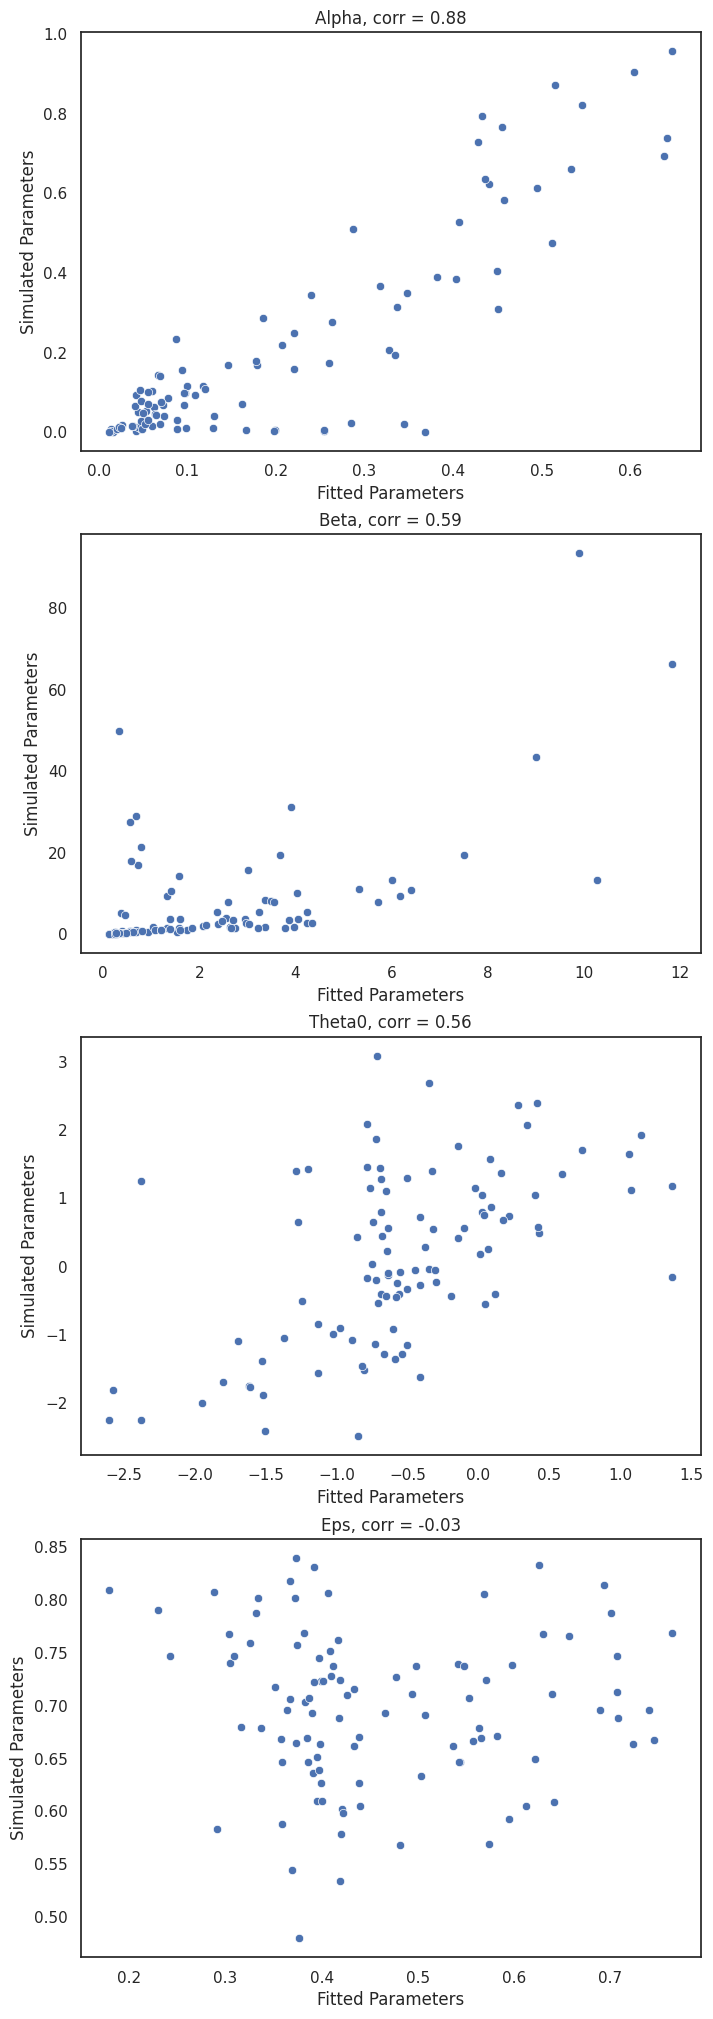

In [9]:
# vector of parameter names
param_names = ['Alpha', 'Beta', 'Theta0', 'Eps']
sns.set_theme(rc={'figure.figsize':(8,25)})
sns.set_style(style='white')

# build figure space
fig, axs = plt.subplots(4)

# loop over n_params and plot recoverd against ground truth
for i in range(len(param_names)):

    # get correlation and "corr = x" into the title
    correlation = np.round(np.corrcoef(fit['m'][:,i],parameters[:,i])[0,1], decimals = 2)
    param_names[i] = param_names[i] + ", corr = " + str(correlation)

    sns.scatterplot(x=fit['m'][:,i], y=parameters[:,i], ax=axs[i])
    axs[i].set_xlabel("Fitted Parameters")
    axs[i].set_ylabel("Simulated Parameters")
    axs[i].set_title(param_names[i])

/tmp/ipykernel_2542137/2165064488.py:83: RuntimeWarning: Mean of empty slice
  stage_means = np.nanmean(trials_ld, axis = 0)
/mnt/Analyses/rowan/dl_modelling/.venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


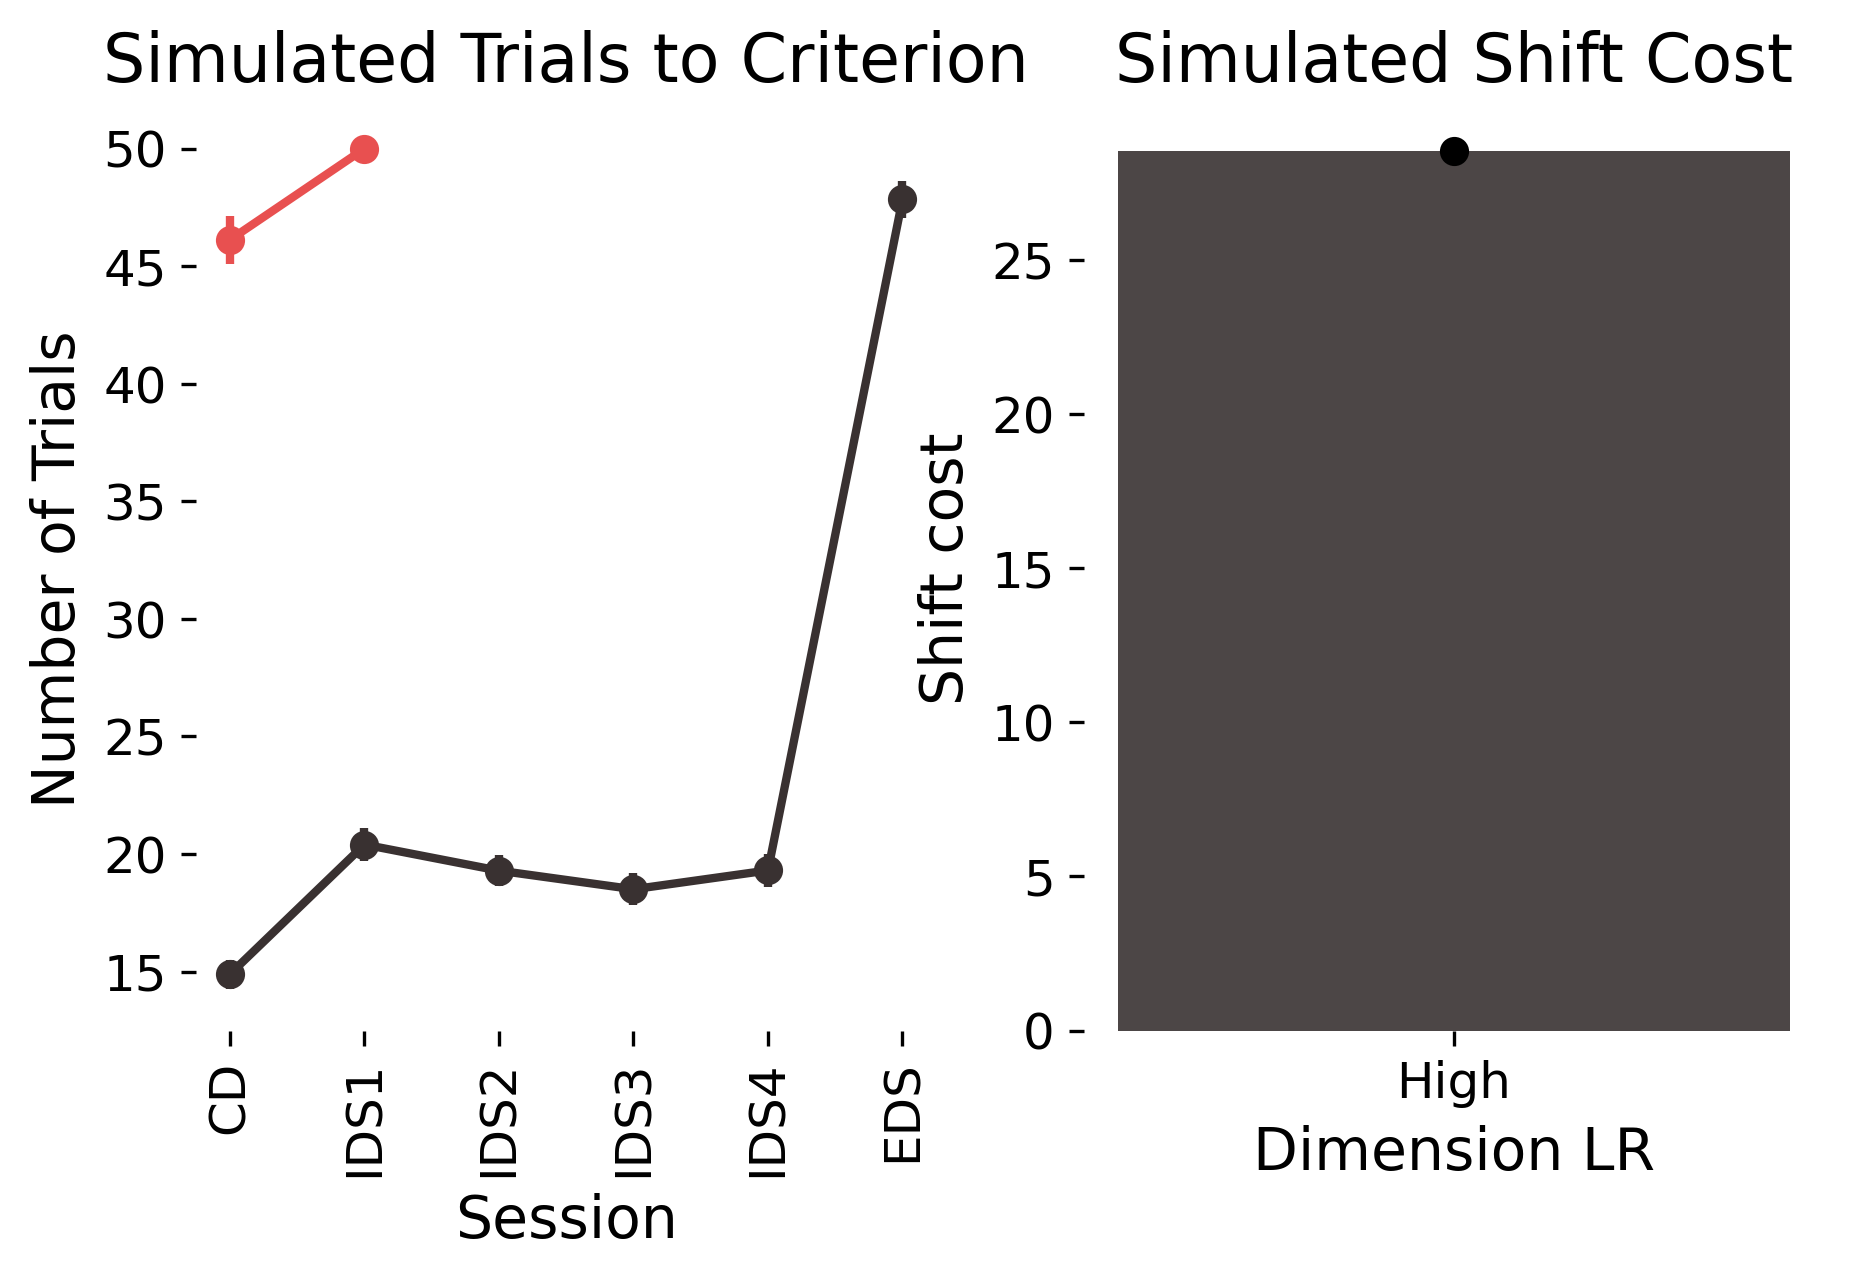

In [30]:
## let's generate some fixed parameters and simulate multiple ppts of each set of fixed params

# empty parameter array
params = np.zeros((200,4))


# fixed parameter vals
params[:100,0] = 0.17 # high alpha f
params[100:,0] = 0.09 # high alpha f
params[:100,1] = 0.01 # temp
params[100:,1] = 1.57 # temp
params[:100,2] = 1.34 # theta_p
params[100:,2] = 0.22 # theta_p
params[:100,3] = 0.12 # low alpha d for first 100
params[100:,3] = 0.70 # high alpha d for 2nd 100

# simulate all 200
sims = modelling.simulate(model = safrl.simulate, model_args = 0, rng = None, seed = 999, params=params, dist=None, N=200, transforms = None, subjects = None)

# lets calculate average trials to criterion by stage 
stages = ['SD', 'CD', 'IDS1', 'IDS2', 'IDS3', 'IDS4', 'EDS', 'EDSR']

# split the data into low d learners and high d learners
ld_data = sims['data'][:100]
hd_data = sims['data'][100:]
data = [hd_data, ld_data]

# plotting vars
data_names = ['High', 'Low', ]
data_colours = ['#393131','#e85050']

# for plotting
n = len(data)

# lets get trials to criterion for each block fo
trials_ld = np.zeros((100, 8))
trials_hd = np.zeros((100, 8))
shift_costs = np.zeros((100, 2))

# Set global font sizes
plt.rcParams.update({'axes.titlesize': 16,
                     'axes.titleweight': 'normal',
                     'axes.labelsize': 14,
                     'axes.labelweight': 'normal',
                     'xtick.labelsize': 12,
                     #'xtick.labelweight': 'bold',
                     'ytick.labelsize': 12,
                     #'ytick.labelweight': 'bold',
                     'legend.fontsize': 12,
                     'font.weight': 'normal'})

# create figure of blank subplots 
fig,ax=plt.subplots(1,n,figsize=(n*3.5,4), dpi= 300, facecolor='w', edgecolor='k')

for j in range(len(data)):
    for i in range(len(data[j])):

        #  get the number of stages they completed
        x = len(data[j][i]['n_trials']) 

        if j == 0:
            trials_hd[i][0:x] = data[j][i]['n_trials']
        else:
            trials_ld[i][0:x] = data[j][i]['n_trials']
            
    trials_hd = np.where(trials_hd == 0, np.nan, trials_hd)
    trials_ld = np.where(trials_ld == 0, np.nan, trials_ld)
    # calculate means and sds
    if j == 0:
        stage_means = np.nanmean(trials_hd, axis = 0)
        stage_sems = np.nanstd(trials_hd, axis = 0)/np.sqrt(len(trials_hd))
        shift_costs[:,0] = trials_hd[:,6] - trials_hd[:,5]
    else:
        stage_means = np.nanmean(trials_ld, axis = 0)
        stage_sems = np.nanstd(trials_ld, axis = 0)/np.sqrt(len(trials_hd))
        shift_costs[:,1] = trials_ld[:,6] - trials_ld[:,5]

    plt.sca(ax[0])
    plt.errorbar(stages[1:7], stage_means[1:7], yerr= stage_sems[1:7], fmt='o-', color = data_colours[j], capsize=0, elinewidth = 2, linewidth = 2)
    plt.title('Simulated Trials to Criterion')
    plt.xlabel('Session')
    plt.ylabel('Number of Trials')
    plt.xticks(rotation = 90)
    plt.box(False)


plt.sca(ax[1])
sns.barplot(x = data_names, y = np.mean(shift_costs, axis = 0), hue = data_names, palette = data_colours, alpha = 0.9)
plt.errorbar(data_names, y = np.mean(shift_costs, axis = 0), yerr=np.std(shift_costs)/np.sqrt(len(shift_costs)), fmt="o", color="black")
plt.title('Simulated Shift Cost')
plt.ylabel('Shift cost')
plt.xlabel('Dimension LR')
plt.box(False)


In [4]:
check = sims['data'][0]

In [3]:
x = sims['data'][0]
y = sims['data'][100]

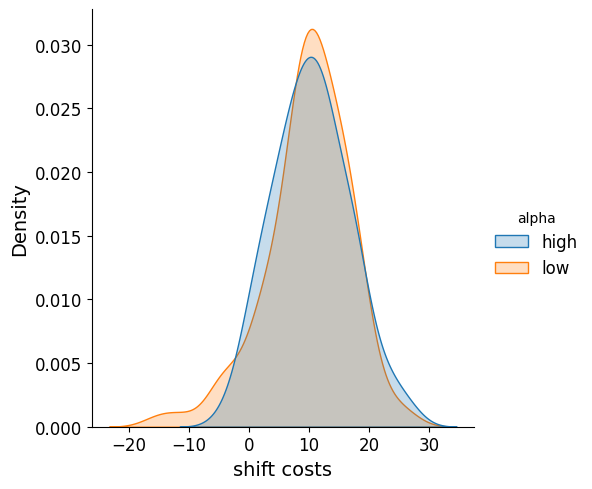

In [42]:
costs = shift_costs[:,0].tolist() + shift_costs[:,1].tolist()
alpha_labels = ['high', 'low']
alpha_labels = np.repeat(alpha_labels, 100)

dict = {'shift costs': costs, 'alpha': alpha_labels}

tmp_df = pd.DataFrame(dict)

sns.displot(tmp_df, x='shift costs', hue='alpha', kind="kde", fill=True)

<Axes: xlabel='stage', ylabel='n_trials'>

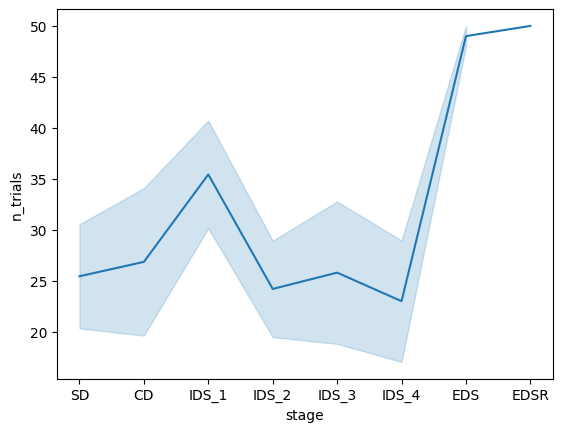

In [10]:
params = np.array([[ 7.38287526e-03,  1.84857226e+01,  7.80502521e-01],
       [ 4.24094998e-02,  4.40749688e+00,  1.36876943e+00],
       [ 2.45527595e-02,  5.94997629e+00,  5.41616827e-01],
       [ 9.17187755e-01,  2.69616562e-02,  7.73559928e-01],
       [ 2.41980272e-01,  6.84553121e-01,  1.02052125e+00],
       [ 6.30268750e-02,  2.37794410e+00, -1.11219993e+00],
       [ 6.40833925e-01,  1.35551315e-01,  6.23962475e-01],
       [ 8.25200346e-03,  1.32407933e+01, -1.51637106e+00],
       [ 5.17675865e-02,  2.42543997e+00, -1.23076218e+00]])

sims = modelling.simulate(model = cafrl.simulate, model_args = 0, rng = None, seed = 2, params=params, dist=None, N=9, transforms = None, subjects = None)

for i in range(len(sims['data'])):
    tmp_data = sims['data'][i]
    n_trials = tmp_data['n_trials']
    stages_attempted = tmp_data['stages_attempted']
    
    tmp_df = pd.DataFrame({
        'n_trials': n_trials,
        'stage': stages_attempted,
        'id': [i] * len(stages_attempted)

    })

    if i == 0:
        tmp = tmp_df
    else:
        tmp = pd.concat([tmp, tmp_df])

sns.lineplot(tmp, x='stage', y='n_trials', errorbar='se')